# Kobayayashi Dogleg benchmark analysis 
The *Kobayashi Dogleg* is one of several benchmarks proposed in a neutronics benchmark manuscript, comparing Monte Carlo methods to deterministic methods [1]. \
Monte Carlo results are compared to the deterministic and analytic calculations. \
This uses a 1-group artificial set of scattering and absorption cross-sections. \

In Problem I, there is an asborption probablity inside the shielding material and source material, and a minimal probability of absorption within the duct volume. \

In Problem II, there is both a scattering and absorption probability inside the shielding material and source material, where there is equal probability of scattering and absorption within all 3 materials. 

In this benchmark, the _weight windows_ variance reduction technique is used, where thel weight windows file is produced with the internal OpenMC Magic Method implementation [2].


In [1]:
import openmc_fusion_benchmarks as ofb
import openmc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Extract experimental and codes results from `results_database`

In [2]:
# read benchmark data
experiment_file = ofb.ResultsFromDatabase('Kobayashi_Dogleg_benchmark.h5', path='results_database')

In [3]:
# read openmc results in results_database/
openmc_mgxs_file = ofb.ResultsFromDatabase('openmc-0-14-1_mgxs.h5', path='results_database')

### Flux analysis
There is an analytical expectation only when the total cross-section is equal to the absorption cross-section. There is also a deterministic model, GMVP, that can produce flux estimates when scattering cross-sections are non-zero.  Finally, there is a MCNP monte-carlo model that is most similar to the OpenMC approach.

In [4]:
# initialize reaction rate plots
tally_list = ['3A', '3B', '3C']
problem_labels = ['Problem_I', 'Problem_II']
ylabel = 'Flux'

3A Problem_I


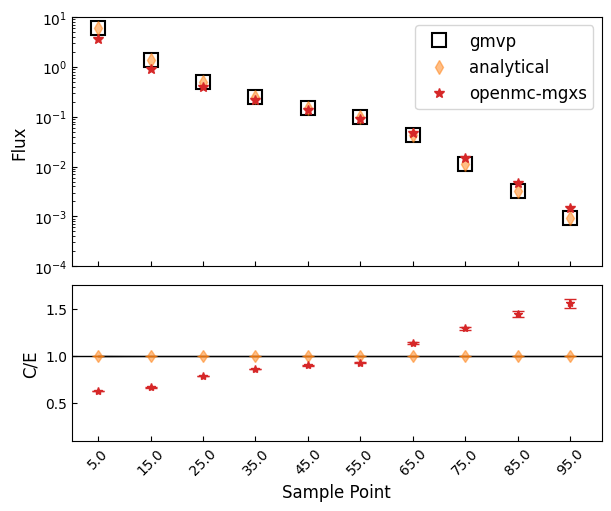

3A Problem_II


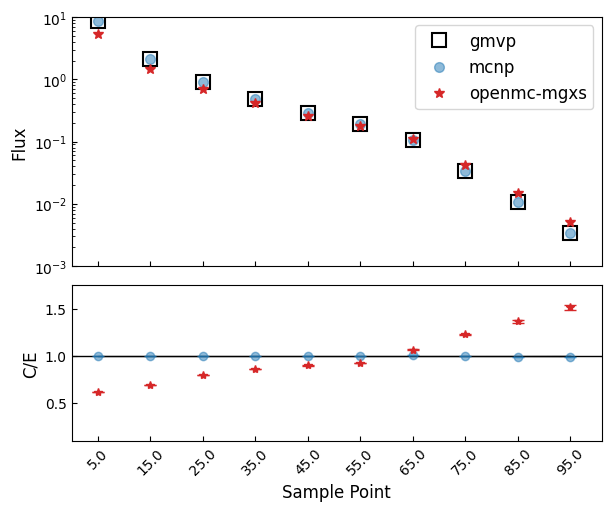

3B Problem_I


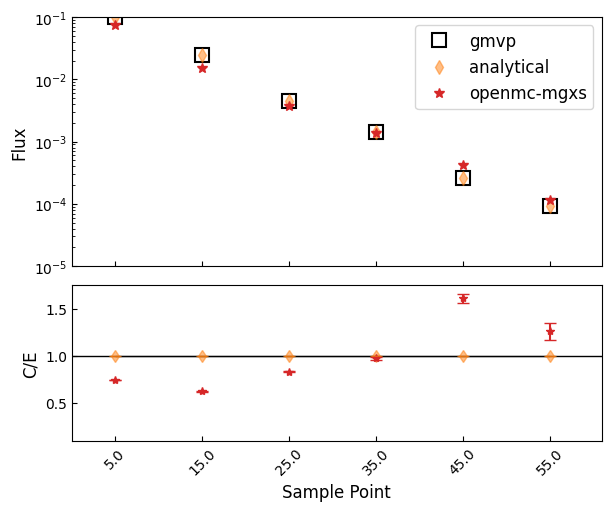

3B Problem_II


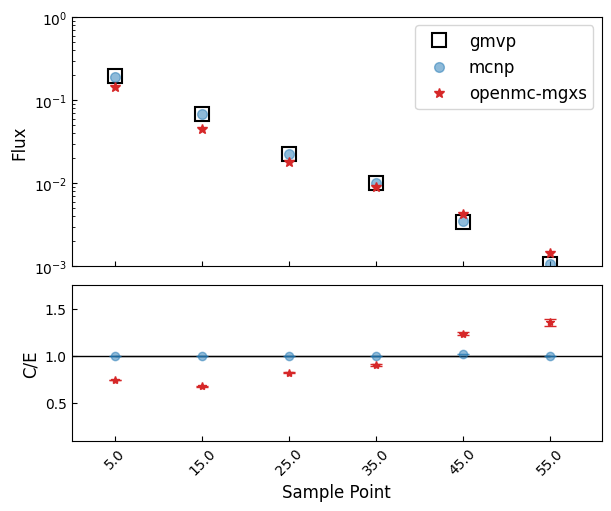

3C Problem_I


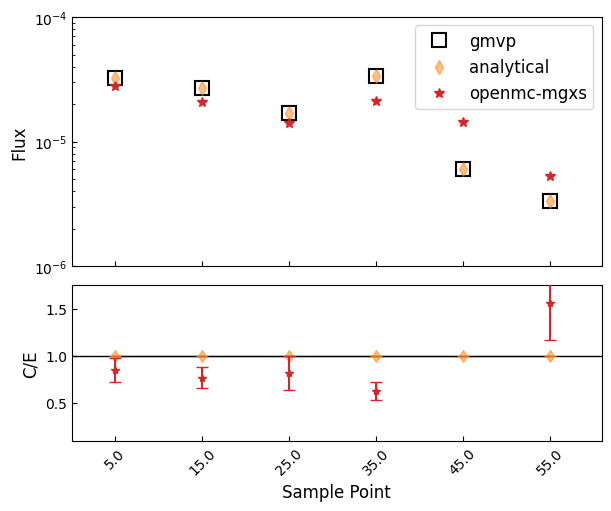

3C Problem_II


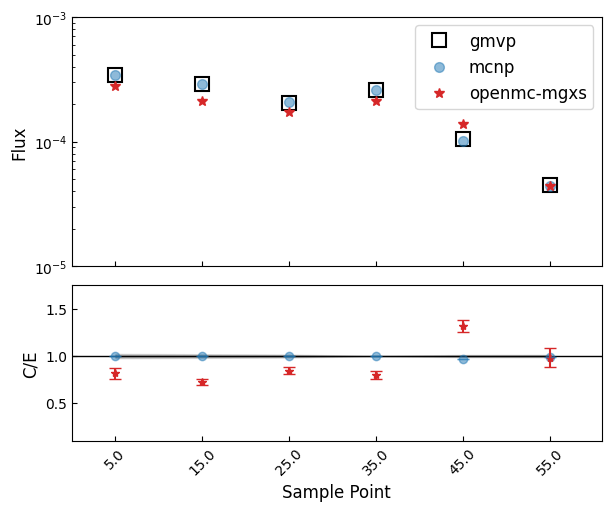

In [5]:
for j in tally_list:
    for i,problem in enumerate(problem_labels):
        print(j,problem)
        # extract tallies
        if i<1:
            analytical = experiment_file.get_tally_dataframe(f'{problem}_analytical_{j}')
        else:
            mcnp = experiment_file.get_tally_dataframe(f'{problem}_mcnp_{j}')
        gmvp = experiment_file.get_tally_dataframe(f'{problem}_gmvp_{j}')

        # openmc from results_database/
        openmc_mgxs = openmc_mgxs_file.get_tally_dataframe(f'{problem}_{j}')

        xaxis = openmc_mgxs_file.get_tally_xaxis(f'{problem}_{j}')
        # plot results and compare
        plot = ofb.PlotReactionRates(xaxis=xaxis, ylabel=ylabel)
        plot.add_reference_results(reference_data=gmvp, label='gmvp')
        #plot.add_reference_results(reference_data=openmc_mgxs, label='ww')
        if i<1:
            plot.add_computed_results(computed_data=analytical, marker='d', color='tab:orange', alpha=.5, label='analytical')
        else:
            plot.add_computed_results(computed_data=mcnp, marker='o', color='tab:blue', alpha=.5, label='mcnp')
        plot.add_computed_results(computed_data=openmc_mgxs, marker='*', color='tab:red', label='openmc-mgxs')
        plt.show()

### Evolution of the weight windows

We're generating 9 iterations of weight windows values and we're ultimately using the 9th for a production run to generate the plots above.  But we can look at the weight windows values themselves on the mesh, along with the relative errors on the mesh, to convince ourselves that the iterative approach has sufficiently reduced statistical errors in the deeply shielded regions of the geometry.

In [6]:


def plot_mesh_tally_and_weight_window(statepoint_filename, weight_window_filename, image_filename):
   
    geo_mesh = openmc.RegularMesh()
    geo_mesh.dimension = [60,100,60]
    geo_mesh.lower_left = [0,0,0]
    geo_mesh.upper_right =[60,100,60]

    plt.figure(figsize=(12,6))
    
    with openmc.StatePoint(statepoint_filename) as sp:
        flux_tally = sp.get_tally(name= 'Flux Tally')

    tally_mesh = flux_tally.find_filter(openmc.MeshFilter).mesh
    tally_mesh_extent = geo_mesh.bounding_box.extent['xy']

    # get a slice of mean values on the xy basis z=0 axis
    flux_mean = flux_tally.get_reshaped_data(value='mean', expand_dims=True).squeeze()[:,:,0] # originating at z = 0
    plt.subplot(2,3,1) # makes a 2x3 plot displayed 1st
    plt.tight_layout()
    # create a plot of the mean flux values
    plt.imshow(
        flux_mean.T,
        origin="lower",
        extent=tally_mesh_extent,
        norm=LogNorm(),
        aspect='auto',
        interpolation='nearest'
    )
    plt.colorbar()
    plt.title("Flux Mean")
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')

    # get a slice of relative error values on the xy basis z = 0 
    flux_std_dev = flux_tally.get_reshaped_data(value='rel_err', expand_dims=True).squeeze()[:,:,0] # originating at z = 0
    plt.subplot(2,3,2) # makes a 2x3 plot displayed 2nd
    plt.tight_layout() # this will fix the overlap on plots
    # create a plot of the flux relative error
    plt.imshow(
        flux_std_dev.T,
        origin="lower",
        extent=tally_mesh_extent,
        aspect='auto',
        norm=LogNorm(vmin=1e-4,vmax=1),
        interpolation='nearest'
    )
    plt.colorbar()
    plt.title("Flux Rel. Err.")
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    
 
    wws_=openmc.hdf5_to_wws(weight_window_filename)
    ww = wws_[0]  # get the one and only mesh tally
    ww_mesh = ww.mesh  # get the mesh that the weight window is mapped on
    ww_mesh_extent = ww_mesh.bounding_box.extent['xy']
    # this is calling the upper bound and shaping it to create plot
    reshaped_ww_vals_upper = ww.upper_ww_bounds.reshape(geo_mesh.dimension)
   
    # get a slice on XY basis, at z = 0
    slice_of_ww_upper = reshaped_ww_vals_upper[:,:,0]
    plt.subplot(2,3,3)
    plt.tight_layout()
    # create a plot of the ww upper bounds
    plt.imshow(
        slice_of_ww_upper.T,
        origin="lower",
        extent=ww_mesh_extent,
        norm=LogNorm(),
        aspect='auto',
        interpolation='nearest'
    )
    plt.colorbar()
    plt.title("Weight Window Upper Bound")
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    
    #plt.savefig(image_filename, bbox_inches="tight")

/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)


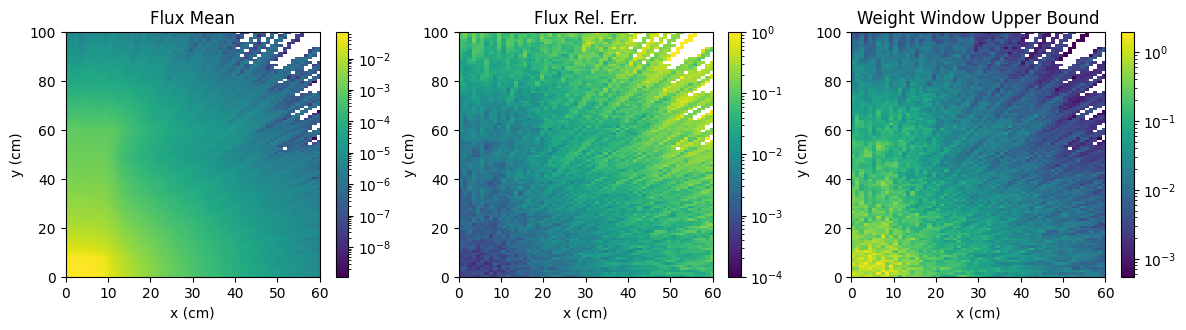

/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


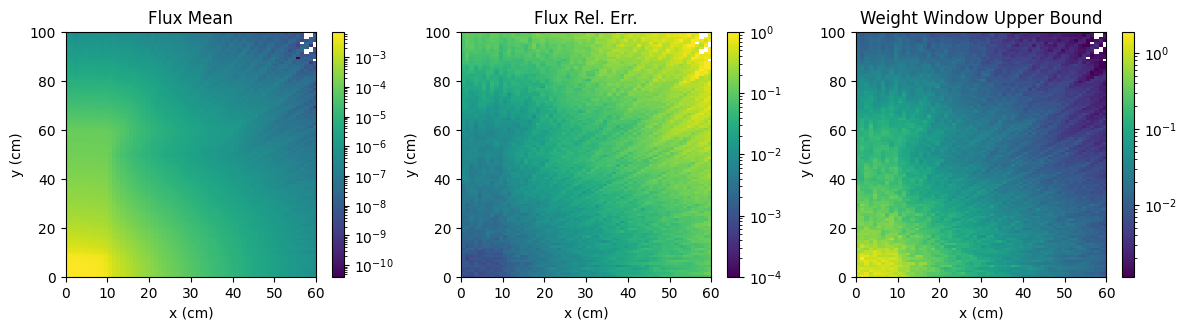

/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


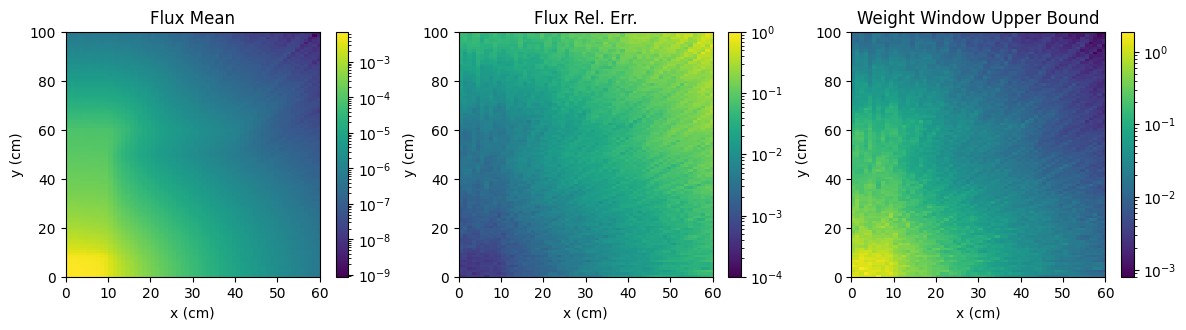

In [7]:
plot_mesh_tally_and_weight_window("Problem_I/statepoint.20.0.h5","Problem_I/weight_windows0.h5", "")
plt.show()
plot_mesh_tally_and_weight_window("Problem_I/statepoint.20.5.h5","Problem_I/weight_windows5.h5", "")
plt.show()
plot_mesh_tally_and_weight_window("Problem_I/statepoint.20.9.h5","Problem_I/weight_windows9.h5", "")
plt.show()

/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


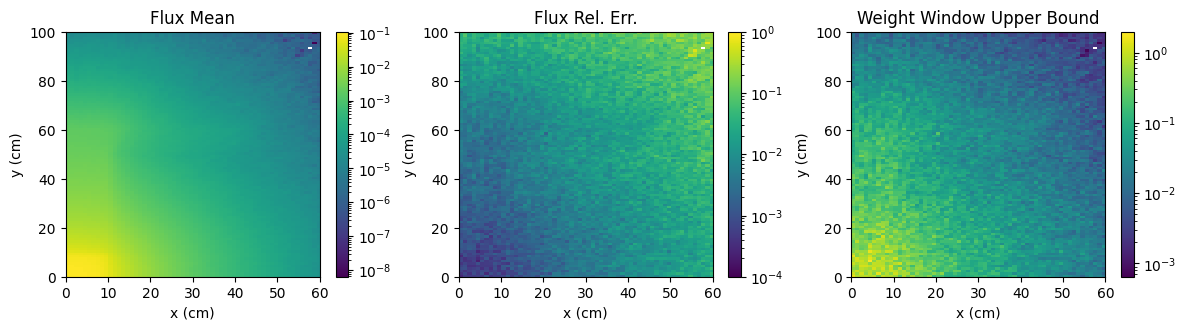

/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


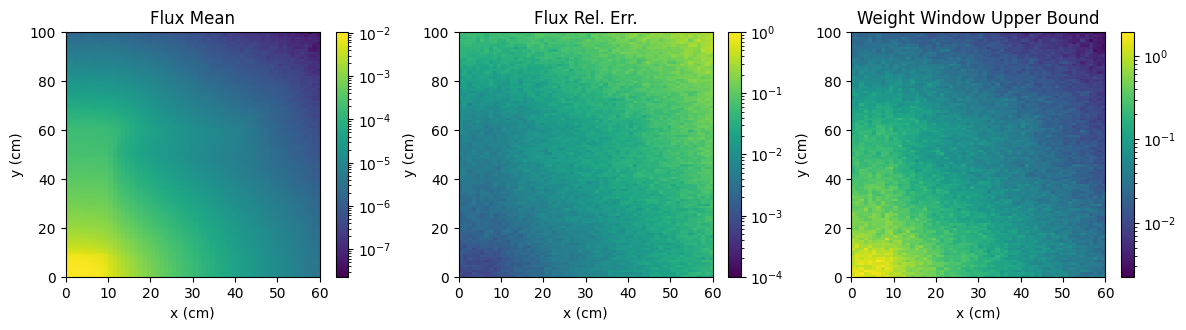

/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=1.
  warn(msg, IDWarning)
/home/vagrant/.pyenv/versions/3.9.15/envs/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


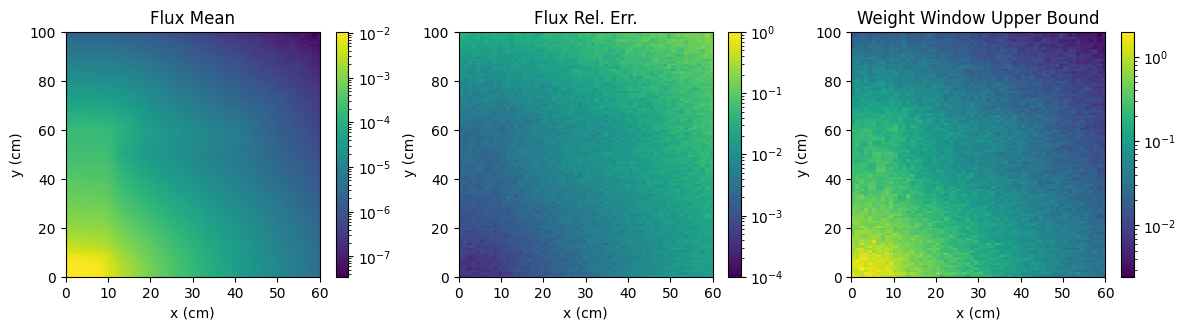

In [8]:
plot_mesh_tally_and_weight_window("Problem_II/statepoint.20.0.h5","Problem_II/weight_windows0.h5", "")
plt.show()
plot_mesh_tally_and_weight_window("Problem_II/statepoint.20.5.h5","Problem_II/weight_windows5.h5", "")
plt.show()
plot_mesh_tally_and_weight_window("Problem_II/statepoint.20.9.h5","Problem_II/weight_windows9.h5", "")
plt.show()

[1] K. Kobayashi, N. Sugimura, Y. Nagaya. "3D radiation transport benchmark problems and results for simple geometries with void region."
Progress in Nuclear Energy, 39:2 (2001) ,pp. 119-144,https://doi.org/10.1016/S0149-1970(01)00007-5.
[2] A. Davis, A. Turner. Application of novel global variance reduction methods to fusion radiation transport problems. M&C 2011: International conference on mathematics and computational methods applied to nuclear science and engineering, Brazil. 